In [1]:
# Now, want to try and simulate multiple objects in the center,
# let's say within 10-10 arcsecond grid
# different fluxes, 
# different temperatures
# temperature determines spectra
# (just simple black bodies)
# first, imports

import dLux as dl
import dLuxToliman as dlT
import dLux.utils as dlu
import dLux.layers as dll
import jax.numpy as np
import jax.random as jr

# astropy for blackbody
from astropy import constants as c
from astropy import units as u

In [2]:
# uniform distribution of positions, fluxes, temperatures
key = jr.PRNGKey(0)
n_sources = 10

positions = dlu.arcsec2rad(jr.uniform(key, (n_sources,2), minval=-10,maxval=10))

# logged distribution of fluxes
fluxes = 10**jr.uniform(key, (n_sources,), minval=5, maxval=8)

# wavelengths (100 of them) defined by our bandpass
wavelengths = np.linspace(530e-9, 640e-9, 200)

# temperatures just gonna be exponential decay, starts at 2000
temperatures = 10000*jr.exponential(key,(n_sources,)) + 2000


# weights defined by planck
def planck(wavelength, T):
    # Planck's law for blackbody radiation
    return (2 * c.h * c.c**2) / (wavelength**5 * (np.exp((c.h * c.c) / (wavelength * c.k_B * T)) - 1))

# make this part a for loop which gives normalised intensities for each temperature (indexed properly)
# Compute normalized intensities for each source
normalized_intensities = []

for i in range(n_sources):
    intensity = planck(wavelengths, temperatures[i])
    normalized = intensity / np.max(intensity)
    normalized_intensities.append(normalized)

# Convert to a NumPy array: shape (n_sources, 100)
normalized_intensities = np.array(normalized_intensities)

sources = []
for i in range(n_sources):
    sources.append(dl.PointSource(wavelengths, positions[i], fluxes[i], normalized_intensities[i]))

In [3]:
# constructing the telescope:
wf_npixels = 256 # nice and low res
diameter = 0.125
period = 304e-6
difference = np.pi

apertureLayer = dlT.TolimanApertureLayer(wf_npixels)

layers = [
    (
        'aperture',
        apertureLayer
    )
]

psf_npixels = 128
pixel_scale = 1
oversample = 4 # high level oversample

optics = dl.AngularOpticalSystem(wf_npixels,diameter,layers,psf_npixels,pixel_scale,oversample)

In [4]:
telescope = dl.Telescope(optics, sources)
sidelobescope = dlT.SideLobeTelescope(telescope, period, difference)

In [5]:
center_wl = 585e-9
sidelobes = sidelobescope.model_sidelobes(float(center_wl))

Model time: 37.5345 seconds.


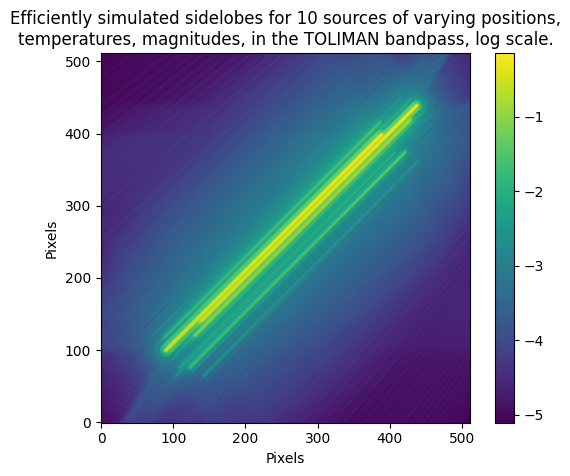

In [6]:
import matplotlib.pyplot as plt
plt.imshow(np.log10(sidelobes),origin='lower')
plt.title(f'Efficiently simulated sidelobes for {n_sources} sources of varying positions,\n'
          f'temperatures, magnitudes, in the TOLIMAN bandpass, log scale.')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.colorbar()
plt.show()

In [7]:
# Still... takes 40 seconds to simulate.
# Kinda expected. Have 200 (number of wavelengths) * 10 (number of sources) = 2000 individual sources that need to be simulated.
# Hopefully the way I've done it will permit jaxable autodiff. 
# But the fact that I sorta just call the wavelengths and make a whole bunch of new sources with them has me concerned.
# Hopefully Jax still knows what's up.